In [52]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter("ignore")

In [53]:
path = "../data/database.sqlite"  #Insert path here
conn = sqlite3.connect(path)

In [54]:
%%time
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

CPU times: user 3.15 s, sys: 256 ms, total: 3.4 s
Wall time: 3.4 s


In [55]:
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)
match_data = match_data.tail(1500)

In [56]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.ix[0]     

def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data

In [58]:
match = match_data[match_data.match_api_id == 1988799]

In [59]:
match

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA


In [50]:
## Generating features, exploring the data, and preparing data for model training
#Generating or retrieving already existant FIFA data
fifa_data = get_fifa_data(match, player_stats_data, data_exists = False)

Fifa data collected in 0.0 minutes


In [51]:
fifa_data

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA


In [41]:
def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    #Return label        
    return label.loc[0]
    


def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''
    
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches
    
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''
    
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches
    
def get_goals(matches, team):
    ''' Get the goals of a specfic team from a set of matches. '''
    
    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    #Return total goals
    return total_goals

def get_goals_conceided(matches, team):
    ''' Get the goals conceided of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    #Return total goals
    return total_goals

def get_wins(matches, team):
    ''' Get the number of wins of a specfic team from a set of matches. '''
    
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    #Return total wins
    return total_wins      
    
def get_match_features(match, matches, x = 10):
    ''' Create match specific features for a given match. '''
    
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 10)
    matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id

    #Create match features
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    #Return match features
    return result.loc[0]
    
def create_feables(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
    ''' Create and aggregate features and labels for all matches. '''

    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    
    if verbose == True:
        print("Generating match features...")
    start = time()
    
    #Get match features for all matches
    match_stats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)
    
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating match labels...")
    start = time()
    
    #Create match labels
    labels = matches.apply(get_match_label, axis = 1)
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating bookkeeper data...")
    start = time()
    
    #Get bookkeeper quotas for all matches
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
    bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))

    #Merges features and labels into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
    #Drop NA values
    feables.dropna(inplace = True)
    
    #Return preprocessed data
    return feables
    
def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, 
                     best_components = None, best_params = None):
    ''' Fits a classifier to the training data. '''
    
    #Start the clock, train the classifier, then stop the clock
    start = time()
    
    #Check if grid search should be applied
    if use_grid_search == True: 
        
        #Define pipeline of dm reduction and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        pipeline = Pipeline(estimators)
        
        #Grid search over pipeline and return best classifier
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_
    else:
        
        #Use best components that are known without grid search        
        estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)        
        best_pipe = pipeline.fit(X_train, y_train)
        
    end = time()
    
    #Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Return best pipe
    return best_pipe
    
def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''
    
    #Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()
    
    #Print and return results
    print("Made predictions in {:.4f} seconds".format(end - start))
    return accuracy_score(target.values, y_pred)
    
def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs, 
                            use_grid_search = True, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''
    
    #Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    #Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
    #Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()    
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    #Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)
        
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs
    
def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
    bk_data = pd.DataFrame()
    
    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        
        #Check if data should be aggregated horizontally
        if(horizontal == True):
            
            #Convert data to probs
            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
            #Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]

            #Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            #Aggregate vertically
            bk_data = bk_data.append(temp_data, ignore_index = True)
    
    #If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
    #Return bookkeeper data
    return bk_data
    
def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
    #Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
    #Convert odds to probabilities
    probs = convert_odds_to_prob(data)
    
    #Return data
    return probs

def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    #Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    #Check if matrix should be normalized
    if normalize == True:
        
        #Normalize
        cm = cm.astype('float') / cm.sum()
        
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred)) 

def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''
    
    #Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
    #Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]
    
    #Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    
    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)
    
    #Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
    for bookkeeper in bookkeepers:
        model_probs = model_probs.append(temp_probs, ignore_index = True)
        label_table = label_table.append(labels)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
    bookkeeper_probs['label'] = label_table 
    
    #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})
                                  
    #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})
                                  
    #Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                  'defeat_prob': 'model_prob'})
    
    total = pd.concat([wins, draws, defeats])
    
    #Return total
    return total
    
def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''
    
    #Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    #Sort by createst difference to identify most underestimated bets    
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)
    
    if verbose == True:
        print("Selecting attractive bets...")
        
    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
    #Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)
    
    #Return choices
    return choices

def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''
    
    #Identify bet
    match = matches[matches.match_api_id == choice.match_api_id]
    bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
    cols = bet_data.columns.values
    cols[:3] = ['win','draw','defeat']
    bet_data.columns = cols
    
    #Identfiy bet type and get quota
    if choice.bet == 'Win':
        bet_quota = bet_data.win.values
    elif choice.bet == 'Draw':
        bet_quota = bet_data.draw.values
    elif choice.bet == 'Defeat':
        bet_quota = bet_data.defeat.values
    else:
        print("Error")
    
    #Check label and compute reward
    if choice.bet == choice.label:
        reward = bet_quota
    else:
        reward = 0
    
    #Return reward
    return reward
      
def execute_bets(bet_choices, matches, verbose = False):
    ''' Get rewards for all bets. '''    
    
    if verbose == True:
        print("Obtaining reward for chosen bets...")
    total_reward = 0
    total_invested = 0
    
    #Loop through bets
    loops = np.arange(0, bet_choices.shape[0])     
    for i in loops:
        
        #Get rewards and accumulate profit
        reward = get_reward(bet_choices.iloc[i,:], matches)
        total_reward = total_reward + reward
        total_invested += 1
    
    #Compute investment return
    investment_return = float(total_reward / total_invested) - 1
    
    #Return investment return
    return investment_return
    
def explore_data(features, inputs, path):
    ''' Explore data by plotting KDE graphs. '''
    
    #Define figure subplots
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
    #Loop through features    
    i = 1
    for col in features.columns:
        
        #Set subplot and plot format        
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(7,7,0 + i)
        j = i - 1
        
        #Plot KDE for all labels
        sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
        sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
        sns.distplot(inputs[inputs['label'] == 'Defeat'].iloc[:,j], hist = False, label = 'Defeat')
        plt.legend();
        i = i + 1
    
    #Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

    plt.show()
    
    #Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)
    
    #Store description of all features
    feature_details = features.describe().transpose()

    #Return feature details
    return feature_details
    
def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
    ''' Tune all classifier and dimensionality reduction combiantions to find best classifier. '''
    
    #Initialize result storage
    clfs_return = []
    dm_reduce_return = []
    train_scores = []
    test_scores = []
    
    #Loop through dimensionality reductions
    for dm in dm_reductions:
        
        #Loop through classifiers
        for clf in clfs:
            
            #Grid search, calibrate, and test the classifier
            clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
                                                      X_calibrate = X_c, y_calibrate = y_c,
                                                      X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                      params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
            
            #Append the result to storage            
            clfs_return.append(clf)
            dm_reduce_return.append(dm_reduce)
            train_scores.append(train_score)
            test_scores.append(test_score)
    
    #Return storage
    return clfs_return, dm_reduce_return, train_scores, test_scores

def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
    ''' Plot results of classifier training. '''
    
    #Set graph format
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
    ax = plt.subplot(111)
    w = 0.5
    x = np.arange(len(train_scores))
    ax.set_yticks(x + w)
    ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
    names = []
    
    #Loop throuugh classifiers
    for i in range(0, len(clfs)): 
        
        #Define temporary variables        
        clf = clfs[i]
        clf_name = clf.base_estimator.__class__.__name__
        dm = dm_reductions[i]
        dm_name = dm.__class__.__name__
        
        #Create and store name
        name = "{} with {}".format(clf_name, dm_name)
        names.append(name)
        
    #Plot all names in horizontal bar plot
    ax.set_yticklabels((names))
    plt.xlim(0.5, 0.55)
    plt.barh(x, test_scores, color = 'b', alpha = 0.6)
    plt.title("Test Data Accuracy Scores")
    fig = plt.figure(1)
    
    plt.show()
    
def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
                     n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
    ''' Tune parameters of bet selection algorithm. '''
    
    #Generate data samples
    samples = []
    for i in range(0, n_samples):
        sample = match_data.sample(n = sample_size, random_state = 42)
        samples.append(sample)
    
    results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
    row = 0
    
    #Iterate over all 1 parameter
    for i in parameter_1_grid:
        
        #Iterate over all 2 parameter
        for j in parameter_2_grid:
            
            #Compute average score over all samples
            profits = []
            for sample in samples:
                choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
                profit = execute_bets(choices, match_data)
                profits.append(profit)
            result = np.mean(np.array(profits))
            results.loc[row,"results"] = result
            results.loc[row,"parameter_1"] = i
            results.loc[row,"parameter_2"] = j
            row = row + 1
            if verbose == True: print("Simulated parameter combination: {}".format(row))
               
    #Return best setting and result
    best_result = results.ix[results['results'].idxmax()] 
    return best_result
    
    
def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose = False, normalize = True):
    ''' Plot confusion matrix of bookkeeper predictions. '''
    
    if verbose == True: print("Obtaining labels...")
    
    #Get match labels
    y_test_temp = matches.apply(get_match_label, axis = 1)
    
    if verbose == True: print("Obtaining bookkeeper probabilities...")
    
    #Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    bookkeeper_probs.dropna(inplace = True)
    
    if verbose == True: print("Obtaining bookkeeper labels...")
    
    #Get bookkeeper labels
    y_pred_temp = pd.DataFrame()
    y_pred_temp.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis = 1)
    y_pred_temp.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
    
    if verbose == True: print("Plotting confusion matrix...")
    
    #Format data
    results = pd.merge(y_pred_temp, y_test_temp, on = 'match_api_id', how = 'left')
    y_test = results.loc[:, 'label']
    y_pred = results.loc[:, 'bk_label']
    
    #Generate confusion matrix
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, y_pred, labels) 
    
    #Check for normalization
    if normalize == True:
        cm = cm.astype('float') / cm.sum()
        
    #Plot confusion matrix
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title = "Confusion matrix of Bookkeeper predictions!"   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report and accuracy score of bookkeepers
    print(classification_report(y_test, y_pred)) 
    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))

In [64]:
#Creating features and labels based on data provided
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']      
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

Generating match features...
Match features generated in 0.5 minutes
Generating match labels...
Match labels generated in 0.1 minutes
Generating bookkeeper data...
Bookkeeper data generated in 0.0 minutes


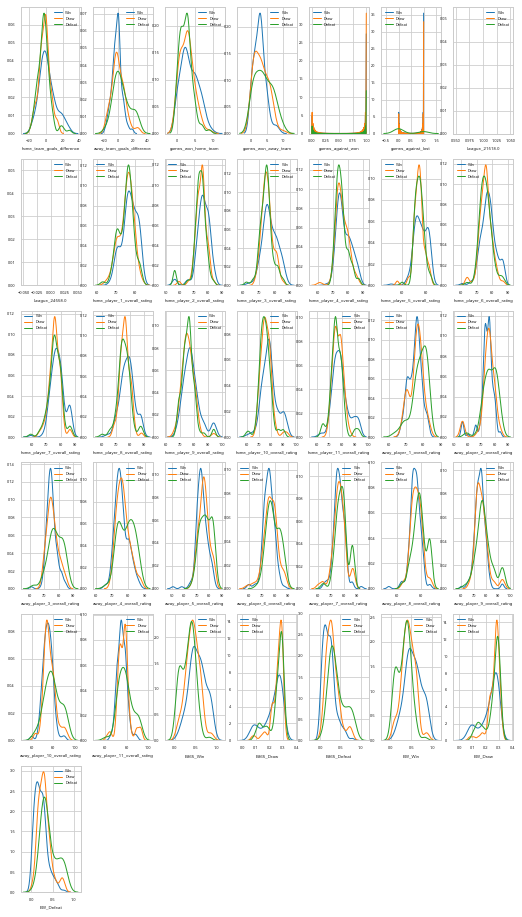

Win       0.481366
Defeat    0.279503
Draw      0.239130
Name: label, dtype: float64


In [65]:
#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
features.head(5)
feature_details = explore_data(features, inputs, path)

In [66]:
#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, 
                                                                        stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)

#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

5

In [67]:
X_train.head()

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_21518.0,League_24558.0,home_player_1_overall_rating,home_player_2_overall_rating,...,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat
172,0.0,-3.0,0.0,0.0,0.0,0.0,1,0,74.0,73.0,...,78.0,74.0,80.0,78.0,0.200765,0.254302,0.544933,0.213483,0.252809,0.533708
148,-6.0,9.0,4.0,6.0,1.0,0.0,1,0,76.0,78.0,...,79.0,78.0,79.0,78.0,0.432203,0.288136,0.279661,0.435940,0.288391,0.275668
68,15.0,3.0,6.0,3.0,0.0,0.0,1,0,81.0,81.0,...,74.0,75.0,73.0,78.0,0.850202,0.104858,0.044939,0.836598,0.109953,0.053449
181,-6.0,-7.0,3.0,2.0,0.0,0.0,1,0,77.0,76.0,...,73.0,73.0,74.0,74.0,0.453278,0.292887,0.253835,0.441345,0.287543,0.271112
89,5.0,-12.0,6.0,1.0,0.0,0.0,1,0,78.0,79.0,...,74.0,68.0,73.0,79.0,0.659577,0.220875,0.119548,0.629224,0.232813,0.137963


In [69]:
X_train.columns

Index(['home_team_goals_difference', 'away_team_goals_difference',
       'games_won_home_team', 'games_won_away_team', 'games_against_won',
       'games_against_lost', 'League_21518.0', 'League_24558.0',
       'home_player_1_overall_rating', 'home_player_2_overall_rating',
       'home_player_3_overall_rating', 'home_player_4_overall_rating',
       'home_player_5_overall_rating', 'home_player_6_overall_rating',
       'home_player_7_overall_rating', 'home_player_8_overall_rating',
       'home_player_9_overall_rating', 'home_player_10_overall_rating',
       'home_player_11_overall_rating', 'away_player_1_overall_rating',
       'away_player_2_overall_rating', 'away_player_3_overall_rating',
       'away_player_4_overall_rating', 'away_player_5_overall_rating',
       'away_player_6_overall_rating', 'away_player_7_overall_rating',
       'away_player_8_overall_rating', 'away_player_9_overall_rating',
       'away_player_10_overall_rating', 'away_player_11_overall_rating',
       'B

In [68]:
y_train.head()

172    Draw
148    Draw
68      Win
181    Draw
89     Draw
Name: label, dtype: object